# Tutorial 2: Introduction to PyTorch

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)   
**Recordings:** 
[![YouTube - Part 1](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%201&color=red)](https://youtu.be/wnKZZgFQY-E)
[![YouTube - Part 2](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%202&color=red)](https://youtu.be/schbjeU5X2g)    
**Author:** Phillip Lippe

Welcome to our PyTorch tutorial for the Deep Learning course 2021 at the University of Amsterdam! The following notebook is meant to give a short introduction to PyTorch basics, and get you setup for writing your own neural networks. PyTorch is an open source machine learning framework that allows you to write your own neural networks and optimize them efficiently. However, PyTorch is not the only framework of its kind. Alternatives to PyTorch include [TensorFlow](https://www.tensorflow.org/), [JAX](https://github.com/google/jax#quickstart-colab-in-the-cloud) and [Caffe](http://caffe.berkeleyvision.org/). We choose to teach PyTorch at the University of Amsterdam because it is well established, has a huge developer community (originally developed by Facebook), is very flexible and especially used in research. Many current papers publish their code in PyTorch, and thus it is good to be familiar with PyTorch as well. 
Meanwhile, TensorFlow (developed by Google) is usually known for being a production-grade deep learning library. Still, if you know one machine learning framework in depth, it is very easy to learn another one because many of them use the same concepts and ideas. For instance, TensorFlow's version 2 was heavily inspired by the most popular features of PyTorch, making the frameworks even more similar. 
If you are already familiar with PyTorch and have created your own neural network projects, feel free to just skim this notebook.

We are of course not the first ones to create a PyTorch tutorial. There are many great tutorials online, including the ["60-min blitz"](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) on the official [PyTorch website](https://pytorch.org/tutorials/). Yet, we choose to create our own tutorial which is designed to give you the basics particularly necessary for the practicals, but still understand how PyTorch works under the hood. Over the next few weeks, we will also keep exploring new PyTorch features in the series of Jupyter notebook tutorials about deep learning. 

We will use a set of standard libraries that are often used in machine learning projects. If you are running this notebook on Google Colab, all libraries should be pre-installed. If you are running this notebook locally, make sure you have installed our `dl2021` environment and have activated it.

In [1]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## The Basics of PyTorch

We will start with reviewing the very basic concepts of PyTorch. As a prerequisite, we recommend to be familiar with the `numpy` package as most machine learning frameworks are based on very similar concepts. If you are not familiar with numpy yet, don't worry: here is a [tutorial](https://numpy.org/devdocs/user/quickstart.html) to go through. 

So, let's start with importing PyTorch. The package is called `torch`, based on its original framework [Torch](http://torch.ch/). As a first step, we can check its version:

In [2]:
import torch
print("Using torch", torch.__version__)

Using torch 1.10.0


At the time of writing this tutorial (mid of October 2021), the current stable version is 1.10. You should therefore see the output `Using torch 1.10.0` or `Using torch 1.9.0`, eventually with some extension for the CUDA version on Colab. In case you use the `dl2021` environment, you should see `Using torch 1.10.0`. In general, it is recommended to keep the PyTorch version updated to the newest one. If you see a lower version number than 1.9, make sure you have installed the correct the environment, or ask one of your TAs. In case PyTorch 1.11 or newer will be published during the time of the course, don't worry. The interface between PyTorch versions doesn't change too much, and hence all code should also be runnable with newer versions.

As in every machine learning framework, PyTorch provides functions that are stochastic like generating random numbers. However, a very good practice is to setup your code to be reproducible with the exact same random numbers. This is why we set a seed below. 

In [3]:
torch.manual_seed(42) # Setting the seed

### Tensors

Tensors are the PyTorch equivalent to Numpy arrays, with the addition to also have support for GPU acceleration (more on that later).
The name "tensor" is a generalization of concepts you already know. For instance, a vector is a 1-D tensor, and a matrix a 2-D tensor. When working with neural networks, we will use tensors of various shapes and number of dimensions.

Most common functions you know from numpy can be used on tensors as well. Actually, since numpy arrays are so similar to tensors, we can convert most tensors to numpy arrays (and back) but we don't need it too often.

#### Initialization

Let's first start by looking at different ways of creating a tensor. There are many possible options, the most simple one is to call `torch.Tensor` passing the desired shape as input argument:

In [4]:
x = torch.Tensor(2, 3, 4)
print(x)

tensor([[[-2.0921e+00,  9.9902e-33, -6.8406e-19,  4.5803e-41],
         [-6.8419e-19,  4.5803e-41,  1.9552e-04,  4.2477e+15],
         [-2.1203e-19,  4.5803e-41, -2.1213e-19,  4.5803e-41]],

        [[-5.8784e-05,  2.4339e-24, -2.1203e-19,  4.5803e-41],
         [ 1.3498e+14,  3.0680e-41,  9.9128e-23,  3.6741e-28],
         [-2.1170e-19,  4.5803e-41, -2.1283e-19,  4.5803e-41]]])


The function `torch.Tensor` allocates memory for the desired tensor, but reuses any values that have already been in the memory. To directly assign values to the tensor during initialization, there are many alternatives including:

* `torch.zeros`: Creates a tensor filled with zeros
* `torch.ones`: Creates a tensor filled with ones
* `torch.rand`: Creates a tensor with random values uniformly sampled between 0 and 1
* `torch.randn`: Creates a tensor with random values sampled from a normal distribution with mean 0 and variance 1
* `torch.arange`: Creates a tensor containing the values $N,N+1,N+2,...,M$
* `torch.Tensor` (input list): Creates a tensor from the list elements you provide

In [5]:
# Create a tensor from a (nested) list
x = torch.Tensor([[1, 2], [3, 4]])
print(x)

tensor([[1., 2.],
        [3., 4.]])


In [6]:
# Create a tensor with random values between 0 and 1 with the shape [2, 3, 4]
x = torch.rand(2, 3, 4)
print(x)

tensor([[[0.8823, 0.9150, 0.3829, 0.9593],
         [0.3904, 0.6009, 0.2566, 0.7936],
         [0.9408, 0.1332, 0.9346, 0.5936]],

        [[0.8694, 0.5677, 0.7411, 0.4294],
         [0.8854, 0.5739, 0.2666, 0.6274],
         [0.2696, 0.4414, 0.2969, 0.8317]]])


You can obtain the shape of a tensor in the same way as in numpy (`x.shape`), or using the `.size` method:

In [7]:
shape = x.shape
print("Shape:", x.shape)

size = x.size()
print("Size:", size)

dim1, dim2, dim3 = x.size()
print("Size:", dim1, dim2, dim3)

Shape: torch.Size([2, 3, 4])
Size: torch.Size([2, 3, 4])
Size: 2 3 4


#### Tensor to Numpy, and Numpy to Tensor

Tensors can be converted to numpy arrays, and numpy arrays back to tensors. To transform a numpy array into a tensor, we can use the function `torch.from_numpy`:

In [8]:
np_arr = np.array([[1, 2], [3, 4]])
tensor = torch.from_numpy(np_arr)

print("Numpy array:", np_arr)
print("PyTorch tensor:", tensor)

Numpy array: [[1 2]
 [3 4]]
PyTorch tensor: tensor([[1, 2],
        [3, 4]])


To transform a PyTorch tensor back to a numpy array, we can use the function `.numpy()` on tensors:

In [9]:
tensor = torch.arange(4)
np_arr = tensor.numpy()

print("PyTorch tensor:", tensor)
print("Numpy array:", np_arr)

PyTorch tensor: tensor([0, 1, 2, 3])
Numpy array: [0 1 2 3]


The conversion of tensors to numpy require the tensor to be on the CPU, and not the GPU (more on GPU support in a later section). In case you have a tensor on GPU, you need to call `.cpu()` on the tensor beforehand. Hence, you get a line like `np_arr = tensor.cpu().numpy()`.

#### Operations

Most operations that exist in numpy, also exist in PyTorch. A full list of operations can be found in the [PyTorch documentation](https://pytorch.org/docs/stable/tensors.html#), but we will review the most important ones here.

The simplest operation is to add two tensors:

In [10]:
x1 = torch.rand(2, 3)
x2 = torch.rand(2, 3)
y = x1 + x2

print("X1", x1)
print("X2", x2)
print("Y", y)

X1 tensor([[0.1053, 0.2695, 0.3588],
        [0.1994, 0.5472, 0.0062]])
X2 tensor([[0.9516, 0.0753, 0.8860],
        [0.5832, 0.3376, 0.8090]])
Y tensor([[1.0569, 0.3448, 1.2448],
        [0.7826, 0.8848, 0.8151]])


Calling `x1 + x2` creates a new tensor containing the sum of the two inputs. However, we can also use in-place operations that are applied directly on the memory of a tensor. We therefore change the values of `x2` without the chance to re-accessing the values of `x2` before the operation. An example is shown below:

In [11]:
x1 = torch.rand(2, 3)
x2 = torch.rand(2, 3)
print("X1 (before)", x1)
print("X2 (before)", x2)

x2.add_(x1)
print("X1 (after)", x1)
print("X2 (after)", x2)

X1 (before) tensor([[0.5779, 0.9040, 0.5547],
        [0.3423, 0.6343, 0.3644]])
X2 (before) tensor([[0.7104, 0.9464, 0.7890],
        [0.2814, 0.7886, 0.5895]])
X1 (after) tensor([[0.5779, 0.9040, 0.5547],
        [0.3423, 0.6343, 0.3644]])
X2 (after) tensor([[1.2884, 1.8504, 1.3437],
        [0.6237, 1.4230, 0.9539]])


In-place operations are usually marked with a underscore postfix (e.g. "add_" instead of "add").

Another common operation aims at changing the shape of a tensor. A tensor of size (2,3) can be re-organized to any other shape with the same number of elements (e.g. a tensor of size (6), or (3,2), ...). In PyTorch, this operation is called `view`:

In [12]:
x = torch.arange(6)
print("X", x)

X tensor([0, 1, 2, 3, 4, 5])


In [13]:
x = x.view(2, 3)
print("X", x)

X tensor([[0, 1, 2],
        [3, 4, 5]])


In [14]:
x = x.permute(1, 0) # Swapping dimension 0 and 1
print("X", x)

X tensor([[0, 3],
        [1, 4],
        [2, 5]])


Other commonly used operations include matrix multiplications, which are essential for neural networks. Quite often, we have an input vector $\mathbf{x}$, which is transformed using a learned weight matrix $\mathbf{W}$. There are multiple ways and functions to perform matrix multiplication, some of which we list below:

* `torch.matmul`: Performs the matrix product over two tensors, where the specific behavior depends on the dimensions. If both inputs are matrices (2-dimensional tensors), it performs the standard matrix product. For higher dimensional inputs, the function supports broadcasting (for details see the [documentation](https://pytorch.org/docs/stable/generated/torch.matmul.html?highlight=matmul#torch.matmul)). Can also be written as `a @ b`, similar to numpy. 
* `torch.mm`: Performs the matrix product over two matrices, but doesn't support broadcasting (see [documentation](https://pytorch.org/docs/stable/generated/torch.mm.html?highlight=torch%20mm#torch.mm))
* `torch.bmm`: Performs the matrix product with a support batch dimension. If the first tensor $T$ is of shape ($b\times n\times m$), and the second tensor $R$ ($b\times m\times p$), the output $O$ is of shape ($b\times n\times p$), and has been calculated by performing $b$ matrix multiplications of the submatrices of $T$ and $R$: $O_i = T_i @ R_i$
* `torch.einsum`: Performs matrix multiplications and more (i.e. sums of products) using the Einstein summation convention. Explanation of the Einstein sum can be found in assignment 1.

Usually, we use `torch.matmul` or `torch.bmm`. We can try a matrix multiplication with `torch.matmul` below.

In [15]:
x = torch.arange(6)
x = x.view(2, 3)
print("X", x)

X tensor([[0, 1, 2],
        [3, 4, 5]])


In [16]:
W = torch.arange(9).view(3, 3) # We can also stack multiple operations in a single line
print("W", W)

W tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])


In [17]:
h = torch.matmul(x, W) # Verify the result by calculating it by hand too!
print("h", h)

h tensor([[15, 18, 21],
        [42, 54, 66]])


#### Indexing

We often have the situation where we need to select a part of a tensor. Indexing works just like in numpy, so let's try it:

In [18]:
x = torch.arange(12).view(3, 4)
print("X", x)

X tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


In [19]:
print(x[:, 1])   # Second column

tensor([1, 5, 9])


In [20]:
print(x[0])      # First row

tensor([0, 1, 2, 3])


In [21]:
print(x[:2, -1]) # First two rows, last column

tensor([3, 7])


In [22]:
print(x[1:3, :]) # Middle two rows

tensor([[ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


### Dynamic Computation Graph and Backpropagation

One of the main reasons for using PyTorch in Deep Learning projects is that we can automatically get **gradients/derivatives** of functions that we define. We will mainly use PyTorch for implementing neural networks, and they are just fancy functions. If we use weight matrices in our function that we want to learn, then those are called the **parameters** or simply the **weights**.

If our neural network would output a single scalar value, we would talk about taking the **derivative**, but you will see that quite often we will have **multiple** output variables ("values"); in that case we talk about **gradients**. It's a more general term.

Given an input $\mathbf{x}$, we define our function by **manipulating** that input, usually by matrix-multiplications with weight matrices and additions with so-called bias vectors. As we manipulate our input, we are automatically creating a **computational graph**. This graph shows how to arrive at our output from our input. 
PyTorch is a **define-by-run** framework; this means that we can just do our manipulations, and PyTorch will keep track of that graph for us. Thus, we create a dynamic computation graph along the way.

So, to recap: the only thing we have to do is to compute the **output**, and then we can ask PyTorch to automatically get the **gradients**. 

> **Note:  Why do we want gradients?** Consider that we have defined a function, a neural net, that is supposed to compute a certain output $y$ for an input vector $\mathbf{x}$. We then define an **error measure** that tells us how wrong our network is; how bad it is in predicting output $y$ from input $\mathbf{x}$. Based on this error measure, we can use the gradients to **update** the weights $\mathbf{W}$ that were responsible for the output, so that the next time we present input $\mathbf{x}$ to our network, the output will be closer to what we want.

The first thing we have to do is to specify which tensors require gradients. By default, when we create a tensor, it does not require gradients.

In [23]:
x = torch.ones((3,))
print(x.requires_grad)

False


We can change this for an existing tensor using the function `requires_grad_()` (underscore indicating that this is a in-place operation). Alternatively, when creating a tensor, you can pass the argument `requires_grad=True` to most initializers we have seen above.

In [24]:
x.requires_grad_(True)
print(x.requires_grad)

True


In order to get familiar with the concept of a computation graph, we will create one for the following function:

$$y = \frac{1}{|x|}\sum_i \left[(x_i + 2)^2 + 3\right]$$

You could imagine that $x$ are our parameters, and we want to optimize (either maximize or minimize) the output $y$. For this, we want to obtain the gradients $\partial y / \partial \mathbf{x}$. For our example, we'll use $\mathbf{x}=[0,1,2]$ as our input.

In [25]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True) # Only float tensors can have gradients
print("X", x)

X tensor([0., 1., 2.], requires_grad=True)


Now let's build the computation graph step by step. You can combine multiple operations in a single line, but we will separate them here to get a better understanding of how each operation is added to the computation graph.

In [26]:
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()
print("Y", y)

Y tensor(12.6667, grad_fn=<MeanBackward0>)


Using the statements above, we have created a computation graph that looks similar to the figure below:

<center style="width: 100%"><img src="pytorch_computation_graph.svg" width="200px"></center>

We calculate $a$ based on the inputs $x$ and the constant $2$, $b$ is $a$ squared, and so on. The visualization is an abstraction of the dependencies between inputs and outputs of the operations we have applied.
Each node of the computation graph has automatically defined a function for calculating the gradients with respect to its inputs, `grad_fn`. You can see this when we printed the output tensor $y$. This is why the computation graph is usually visualized in the reverse direction (arrows point from the result to the inputs). We can perform backpropagation on the computation graph by calling the function `backward()` on the last output, which effectively calculates the gradients for each tensor that has the property `requires_grad=True`:

In [27]:
y.backward()

`x.grad` will now contain the gradient $\partial y/ \partial \mathcal{x}$, and this gradient indicates how a change in $\mathbf{x}$ will affect output $y$ given the current input $\mathbf{x}=[0,1,2]$:

In [28]:
print(x.grad)

tensor([1.3333, 2.0000, 2.6667])


We can also verify these gradients by hand. We will calculate the gradients using the chain rule, in the same way as PyTorch did it:

$$\frac{\partial y}{\partial x_i} = \frac{\partial y}{\partial c_i}\frac{\partial c_i}{\partial b_i}\frac{\partial b_i}{\partial a_i}\frac{\partial a_i}{\partial x_i}$$

Note that we have simplified this equation to index notation, and by using the fact that all operation besides the mean do not combine the elements in the tensor. The partial derivatives are:

$$
\frac{\partial a_i}{\partial x_i} = 1,\hspace{1cm}
\frac{\partial b_i}{\partial a_i} = 2\cdot a_i\hspace{1cm}
\frac{\partial c_i}{\partial b_i} = 1\hspace{1cm}
\frac{\partial y}{\partial c_i} = \frac{1}{3}
$$

Hence, with the input being $\mathbf{x}=[0,1,2]$, our gradients are $\partial y/\partial \mathbf{x}=[4/3,2,8/3]$. The previous code cell should have printed the same result.

### GPU support

A crucial feature of PyTorch is the support of GPUs, short for Graphics Processing Unit. A GPU can perform many thousands of small operations in parallel, making it very well suitable for performing large matrix operations in neural networks. When comparing GPUs to CPUs, we can list the following main differences (credit: [Kevin Krewell, 2009](https://blogs.nvidia.com/blog/2009/12/16/whats-the-difference-between-a-cpu-and-a-gpu/)) 

<center style="width: 100%"><img src="comparison_CPU_GPU.png" width="700px"></center>

CPUs and GPUs have both different advantages and disadvantages, which is why many computers contain both components and use them for different tasks. In case you are not familiar with GPUs, you can read up more details in this [NVIDIA blog post](https://blogs.nvidia.com/blog/2009/12/16/whats-the-difference-between-a-cpu-and-a-gpu/) or [here](https://www.intel.com/content/www/us/en/products/docs/processors/what-is-a-gpu.html). 

GPUs can accelerate the training of your network up to a factor of $100$ which is essential for large neural networks. PyTorch implements a lot of functionality for supporting GPUs (mostly those of NVIDIA due to the libraries [CUDA](https://developer.nvidia.com/cuda-zone) and [cuDNN](https://developer.nvidia.com/cudnn)). First, let's check whether you have a GPU available:

In [29]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


If you have a GPU on your computer but the command above returns False, make sure you have the correct CUDA-version installed. The `dl2021` environment comes with the CUDA-toolkit 11.3, which is selected for the Lisa supercomputer. Please change it if necessary (CUDA 11.1 is currently common on Colab). On Google Colab, make sure that you have selected a GPU in your runtime setup (in the menu, check under `Runtime -> Change runtime type`). 

By default, all tensors you create are stored on the CPU. We can push a tensor to the GPU by using the function `.to(...)`, or `.cuda()`. However, it is often a good practice to define a `device` object in your code which points to the GPU if you have one, and otherwise to the CPU. Then, you can write your code with respect to this device object, and it allows you to run the same code on both a CPU-only system, and one with a GPU. Let's try it below. We can specify the device as follows: 

In [30]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


Now let's create a tensor and push it to the device:

In [31]:
x = torch.zeros(2, 3)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


In case you have a GPU, you should now see the attribute `device='cuda:0'` being printed next to your tensor. The zero next to cuda indicates that this is the zero-th GPU device on your computer. PyTorch also supports multi-GPU systems, but this you will only need once you have very big networks to train (if interested, see the [PyTorch documentation](https://pytorch.org/docs/stable/distributed.html#distributed-basics)). We can also compare the runtime of a large matrix multiplication on the CPU with a operation on the GPU:

In [32]:
x = torch.randn(5000, 5000)

## CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

## GPU version
x = x.to(device)
# CUDA is asynchronous, so we need to use different timing functions
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
_ = torch.matmul(x, x)
end.record()
torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds

CPU time: 0.20055s
GPU time: 0.00760s


Depending on the size of the operation and the CPU/GPU in your system, the speedup of this operation can be >50x. As `matmul` operations are very common in neural networks, we can already see the great benefit of training a NN on a GPU. The time estimate can be relatively noisy here because we haven't run it for multiple times. Feel free to extend this, but it also takes longer to run.

When generating random numbers, the seed between CPU and GPU is not synchronized. Hence, we need to set the seed on the GPU separately to ensure a reproducible code. Note that due to different GPU architectures, running the same code on different GPUs does not guarantee the same random numbers. Still, we don't want that our code gives us a different output every time we run it on the exact same hardware. Hence, we also set the seed on the GPU:

In [33]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Learning by example: Continuous XOR

If we want to build a neural network in PyTorch, we could specify all our parameters (weight matrices, bias vectors) using `Tensors` (with `requires_grad=True`), ask PyTorch to calculate the gradients and then adjust the parameters. But things can quickly get cumbersome if we have a lot of parameters. In PyTorch, there is a package called `torch.nn` that makes building neural networks more convenient. 

We will introduce the libraries and all additional parts you might need to train a neural network in PyTorch, using a simple example classifier on a simple yet well known example: XOR. Given two binary inputs $x_1$ and $x_2$, the label to predict is $1$ if either $x_1$ or $x_2$ is $1$ while the other is $0$, or the label is $0$ in all other cases. The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function.
Hence, we will learn how to build a small neural network that can learn this function. 
To make it a little bit more interesting, we move the XOR into continuous space and introduce some gaussian noise on the binary inputs. Our desired separation of an XOR dataset could look as follows:

<center style="width: 100%"><img src="continuous_xor.svg" width="350px"></center>

### The model

The package `torch.nn` defines a series of useful classes like linear networks layers, activation functions, loss functions etc. A full list can be found [here](https://pytorch.org/docs/stable/nn.html). In case you need a certain network layer, check the documentation of the package first before writing the layer yourself as the package likely contains the code for it already. We import it below:

In [34]:
import torch.nn as nn

Additionally to `torch.nn`, there is also `torch.nn.functional`. It contains functions that are used in network layers. This is in contrast to `torch.nn` which defines them as `nn.Modules` (more on it below), and `torch.nn` actually uses a lot of functionalities from `torch.nn.functional`. Hence, the functional package is useful in many situations, and so we import it as well here.

In [35]:
import torch.nn.functional as F

#### nn.Module

In PyTorch, a neural network is built up out of modules. Modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:

In [36]:
class MyModule(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Some init for my module
        
    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

The forward function is where the computation of the module is taken place, and is executed when you call the module (`nn = MyModule(); nn(x)`). In the init function, we usually create the parameters of the module, using `nn.Parameter`, or defining other modules that are used in the forward function. The backward calculation is done automatically, but could be overwritten as well if wanted.

#### Simple classifier
We can now make use of the pre-defined modules in the `torch.nn` package, and define our own small neural network. We will use a minimal network with a input layer, one hidden layer with tanh as activation function, and a output layer. In other words, our networks should look something like this:

<center width="100%"><img src="small_neural_network.svg" width="300px"></center>

The input neurons are shown in blue, which represent the coordinates $x_1$ and $x_2$ of a data point. The hidden neurons including a tanh activation are shown in white, and the output neuron in red.
In PyTorch, we can define this as follows:

In [37]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

For the examples in this notebook, we will use a tiny neural network with two input neurons and four hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.

In [38]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


Printing the model lists all submodules it contains. The parameters of a module can be obtained by using its `parameters()` functions, or `named_parameters()` to get a name to each parameter object. For our small neural network, we have the following parameters:

In [39]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


Each linear layer has a weight matrix of the shape `[output, input]`, and a bias of the shape `[output]`. The tanh activation function does not have any parameters. Note that parameters are only registered for `nn.Module` objects that are direct object attributes, i.e. `self.a = ...`. If you define a list of modules, the parameters of those are not registered for the outer module and can cause some issues when you try to optimize your module. There are alternatives, like `nn.ModuleList`, `nn.ModuleDict` and `nn.Sequential`, that allow you to have different data structures of modules. We will use them in a few later tutorials and explain them there. 

### The data

PyTorch also provides a few functionalities to load the training and test data efficiently, summarized in the package `torch.utils.data`.

In [40]:
import torch.utils.data as data

The data package defines two classes which are the standard interface for handling data in PyTorch: `data.Dataset`, and `data.DataLoader`. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.

#### The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [41]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

Let's try to create such a dataset and inspect it:

In [42]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.9632, 0.1117]), tensor(1))


To better relate to the dataset, we visualize the samples below. 

In [43]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

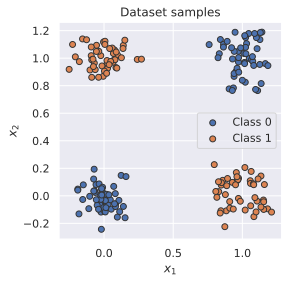

In [44]:
visualize_samples(dataset.data, dataset.label)
plt.show()

#### The data loader class

The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function `__getitem__`, and stacks its outputs as tensors over the first dimension to form a batch.
In contrast to the dataset class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (only a selection, see full list [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)):

* `batch_size`: Number of samples to stack per batch
* `shuffle`: If True, the data is returned in a random order. This is important during training for introducing stochasticity. 
* `num_workers`: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
* `pin_memory`: If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.
* `drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.

Let's create a simple data loader below:

In [45]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [46]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the 
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[-0.0890,  0.8608],
        [ 1.0905, -0.0128],
        [ 0.7967,  0.2268],
        [-0.0688,  0.0371],
        [ 0.8732, -0.2240],
        [-0.0559, -0.0282],
        [ 0.9277,  0.0978],
        [ 1.0150,  0.9689]])
Data labels torch.Size([8]) 
 tensor([1, 1, 1, 0, 1, 0, 1, 0])


### Optimization

After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients

We have seen how we can do step 1, 2 and 4 in PyTorch. Now, we will look at step 3 and 5.

#### Loss modules

We can calculate the loss for a batch by simply performing a few tensor operations as those are automatically added to the computation graph. For instance, for binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:

$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$

where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$. However, PyTorch already provides a list of predefined loss functions which we can use (see [here](https://pytorch.org/docs/stable/nn.html#loss-functions) for a full list). For instance, for BCE, PyTorch has two modules: `nn.BCELoss()`, `nn.BCEWithLogitsLoss()`. While `nn.BCELoss` expects the inputs $x$ to be in the range $[0,1]$, i.e. the output of a sigmoid, `nn.BCEWithLogitsLoss` combines a sigmoid layer and the BCE loss in a single class. This version is numerically more stable than using a plain Sigmoid followed by a BCE loss because of the logarithms applied in the loss function. Hence, it is adviced to use loss functions applied on "logits" where possible (remember to not apply a sigmoid on the output of the model in this case!). For our model defined above, we therefore use the module `nn.BCEWithLogitsLoss`. 

In [47]:
loss_module = nn.BCEWithLogitsLoss()

#### Stochastic Gradient Descent

For updating the parameters, PyTorch provides the package `torch.optim` that has most popular optimizers implemented. We will discuss the specific optimizers and their differences later in the course, but will for now use the simplest of them: `torch.optim.SGD`. Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting those from the parameters (hence minimizing the loss). Therefore, we slowly move towards the direction of minimizing the loss. A good default value of the learning rate for a small network as ours is 0.1. 

In [48]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

The optimizer provides two useful functions: `optimizer.step()`, and `optimizer.zero_grad()`. The step function updates the parameters based on the gradients as explained above. The function `optimizer.zero_grad()` sets the gradients of all parameters to zero. While this function seems less relevant at first, it is a crucial pre-step before performing backpropagation. If we would call the `backward` function on the loss while the parameter gradients are non-zero from the previous batch, the new gradients would actually be added to the previous ones instead of overwriting them. This is done because a parameter might occur multiple times in a computation graph, and we need to sum the gradients in this case instead of replacing them. Hence, remember to call `optimizer.zero_grad()` before calculating the gradients of a batch.

### Training

Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size. 

In [49]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

Now, we can write a small training function. Remember our five steps: load a batch, obtain the predictions, calculate the loss, backpropagate, and update. Additionally, we have to push all data and model parameters to the device of our choice (GPU if available). For the tiny neural network we have, communicating the data to the GPU actually takes much more time than we could save from running the operation on GPU. For large networks, the communication time is significantly smaller than the actual runtime making a GPU crucial in these cases. Still, to practice, we will push the data to GPU here. 

In [50]:
# Push model to device. Has to be only done once
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In addition, we set our model to training mode. This is done by calling `model.train()`. There exist certain modules that need to perform a different forward step during training than during testing (e.g. BatchNorm and Dropout), and we can switch between them using `model.train()` and `model.eval()`.

In [51]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()

In [52]:
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

#### Saving a model

After finish training a model, we save the model to disk so that we can load the same weights at a later time. For this, we extract the so-called `state_dict` from the model which contains all learnable parameters. For our simple model, the state dict contains the following entries:

In [53]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-2.6034, -3.3293],
        [ 1.9773, -2.4074],
        [-2.5968, -1.5909],
        [-0.5714, -0.8096]], device='cuda:0')), ('linear1.bias', tensor([ 1.4459, -1.3992,  2.9883, -0.1376], device='cuda:0')), ('linear2.weight', tensor([[-4.4624,  3.0882,  4.4031, -0.1372]], device='cuda:0')), ('linear2.bias', tensor([-1.6854], device='cuda:0'))])


To save the state dictionary, we can use `torch.save`:

In [54]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

To load a model from a state dict, we use the function `torch.load` to load the state dict from the disk, and the module function `load_state_dict` to overwrite our parameters with the new values:

In [55]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-2.6034, -3.3293],
        [ 1.9773, -2.4074],
        [-2.5968, -1.5909],
        [-0.5714, -0.8096]], device='cuda:0')), ('linear1.bias', tensor([ 1.4459, -1.3992,  2.9883, -0.1376], device='cuda:0')), ('linear2.weight', tensor([[-4.4624,  3.0882,  4.4031, -0.1372]], device='cuda:0')), ('linear2.bias', tensor([-1.6854], device='cuda:0'))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-2.6034, -3.3293],
        [ 1.9773, -2.4074],
        [-2.5968, -1.5909],
        [-0.5714, -0.8096]])), ('linear1.bias', tensor([ 1.4459, -1.3992,  2.9883, -0.1376])), ('linear2.weight', tensor([[-4.4624,  3.0882,  4.4031, -0.1372]])), ('linear2.bias', tensor([-1.6854]))])


A detailed tutorial on saving and loading models in PyTorch can be found [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

### Evaluation

Once we have trained a model, it is time to evaluate it on a held-out test set. As our dataset consist of randomly generated data points, we need to first create a test set with a corresponding data loader.

In [56]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False) 

As metric, we will use accuracy which is calculated as follows:

$$acc = \frac{\#\text{correct predictions}}{\#\text{all predictions}} = \frac{TP+TN}{TP+TN+FP+FN}$$

where TP are the true positives, TN true negatives, FP false positives, and FN the fale negatives. 

When evaluating the model, we don't need to keep track of the computation graph as we don't intend to calculate the gradients. This reduces the required memory and speed up the model. In PyTorch, we can deactivate the computation graph using `with torch.no_grad(): ...`. Remember to additionally set the model to eval mode.

In [57]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.
    
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [58]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


If we trained our model correctly, we should see a score close to 100% accuracy. However, this is only possible because of our simple task, and unfortunately, we usually don't get such high scores on test sets of more complex tasks.

#### Visualizing classification boundaries

To visualize what our model has learned, we can perform a prediction for every data point in a range of $[-0.5, 1.5]$, and visualize the predicted class as in the sample figure at the beginning of this section. This shows where the model has created decision boundaries, and which points would be classified as $0$, and which as $1$. We therefore get a background image out of blue (class 0) and orange (class 1). The spots where the model is uncertain we will see a blurry overlap. The specific code is less relevant compared to the output figure which should hopefully show us a clear separation of classes:

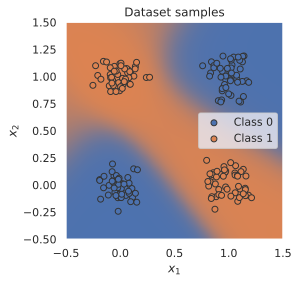

In [59]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

The decision boundaries might not look exactly as in the figure in the preamble of this section which can be caused by running it on CPU or a different GPU architecture. Nevertheless, the result on the accuracy metric should be the approximately the same. 

## Additional features we didn't get to discuss yet

Finally, you are all set to start with your own PyTorch project! In summary, we have looked at how we can build neural networks in PyTorch, and train and test them on data. However, there is still much more to PyTorch we haven't discussed yet. In the comming series of Jupyter notebooks, we will discover more and more functionalities of PyTorch, so that you also get familiar to PyTorch concepts beyond the basics. If you are already interested in learning more of PyTorch, we recommend the official [tutorial website](https://pytorch.org/tutorials/) that contains many tutorials on various topics. Especially logging with Tensorboard ([official tutorial here](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)) is a good practice that we will explore further from Tutorial 5 on in combination with PyTorch Lightning.
Nonetheless, let's check it shortly out how we could use TensorBoard in our small example.

### TensorBoard logging

TensorBoard is a logging and visualization tool that is a popular choice for training deep learning models. Although initially published for TensorFlow, TensorBoard is also integrated in PyTorch allowing us to easily use it. First, let's import it below.

In [60]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%load_ext tensorboard

The last line is required if you want to run TensorBoard directly in the Jupyter Notebook. Otherwise, you can start TensorBoard from the terminal.

PyTorch's TensorBoard API is simple to use. We start the logging process by creating a new object, `writer = SummaryWriter(...)`, where we specify the directory in which the logging file should be saved. With this object, we can log different aspects of our model by calling functions of the style `writer.add_...`. For example, we can visualize the computation graph with the function `writer.add_graph`, or add a scalar value like the loss with `writer.add_scalar`. Let's adapt our initial training function with adding a TensorBoard logger below.

In [61]:
def train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=100, logging_dir='runs/our_experiment'):
    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False
    
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()
            
            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()
            
        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step = epoch + 1)
        
        # Visualize prediction and add figure to TensorBoard
        # Since matplotlib figures can be slow in rendering, we only do it every 10th epoch
        if (epoch + 1) % 10 == 0:
            fig = visualize_classification(model, val_dataset.data, val_dataset.label)
            writer.add_figure('predictions',
                              fig,
                              global_step = epoch + 1)
    
    writer.close()

Let's use this method to train a model as before, with a new model and optimizer.

In [62]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_model_with_logger(model, optimizer, train_data_loader, loss_module, val_dataset=dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

The TensorBoard file in the folder `runs/our_experiment` now contains a loss curve, the computation graph of our network, and a visualization of the learned predictions over number of epochs. To start the TensorBoard visualizer, simply run the following statement:

In [63]:
%tensorboard --logdir runs/our_experiment

<center><img src="tensorboard_screenshot.png" width="1100px"></center>

TensorBoard visualizations can help to identify possible issues with your model, and identify situations such as overfitting. You can also track the training progress while a model is training, since the logger automatically writes everything added to it to the logging file. Feel free to explore the TensorBoard functionalities, and we will make use of TensorBoards a couple of times from Tutorial 5 on.

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---